In [1]:
# Depression Analysis

Depression alone affects more than 300 million people worldwide and is one of the largest cause of disability worldwide, particularly for women.

It is characterized by sadness, loss of weight, loss of interest, suicide attempts etc.

Body sensors have long being used to monitor personal health. This sensors store vast amount of data which holds the potential of measuring the quantity of daily steps, calories burned, continuous recordings of heart rate and activity level.

Dealing with depression can be very demanding and creates a lot of physical, economical and emotional problems. 

Depression is characterized by reduced day time activity and increased night time activity

The dataset collected used in this analysis is public available. The dataset was originally collected for the study of motor activity in schizophrenia and major depression. Motor activity was monitored with an actigraph watch worn at the right wrist (Actiwatch, Cambridge Neurotechnology Ltd, England, model AW4). The actigraph watch measures activity levels. The sampling frequency is 32Hz and movements over 0.05 g are recorded. A corresponding voltage is produced and is stored as an activity count in the memory unit of the actigraph watch.

The number of counts is proportional to the intensity of the movement. Total activity counts were continuously recorded in one minute intervals. This dataset consists of actigraphy data collected from 23 unipolar and bipolar depressed patients (condition group), 5 subjects were hospitalized during their data collection period,
and 18 were outpatients. The severity level of the ongoing depression was rated by a clinician on the Montgomery- Asberg Depression Rating Scale (MADRS) at the beginning and conclusion of the motor-activity recordings. 

In addition, the dataset contains actigraphy data from 32 non-depressed contributors (control group), consisting of 23 hospital employees, 5 students and 4 former patients without current psychiatric symptoms.

In [2]:
import os
from datetime import datetime 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
control_1 = pd.read_csv('/kaggle/input/the-depression-dataset/data/control/control_1.csv')
condition_1 = pd.read_csv('/kaggle/input/the-depression-dataset/data/condition/condition_1.csv')
print(f'control_1.shape: {control_1.shape}')
print(f'condition_1.shape: {condition_1.shape}')

control_1.shape: (51611, 3)
condition_1.shape: (23244, 3)


In [4]:
control_1.head()

,timestamp,date,activity
0,2003-03-18 15:00:00,2003-03-18,60
1,2003-03-18 15:01:00,2003-03-18,0
2,2003-03-18 15:02:00,2003-03-18,264
3,2003-03-18 15:03:00,2003-03-18,662
4,2003-03-18 15:04:00,2003-03-18,293


In [5]:
condition_1.head()

,timestamp,date,activity
0,2003-05-07 12:00:00,2003-05-07,0
1,2003-05-07 12:01:00,2003-05-07,143
2,2003-05-07 12:02:00,2003-05-07,0
3,2003-05-07 12:03:00,2003-05-07,20
4,2003-05-07 12:04:00,2003-05-07,166


In [6]:
condition_1.describe()

,activity
count,23244.000000
mean,146.948030
std,294.592424
min,0.000000
25%,0.000000
50%,9.000000
75%,172.000000
max,3526.000000


<AxesSubplot:xlabel='activity', ylabel='Count'>

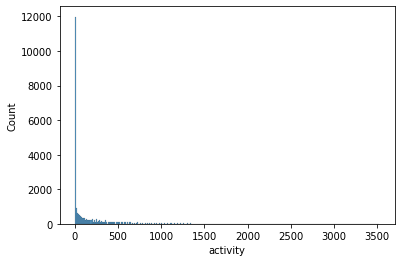

In [7]:
sns.histplot(x='activity', data=condition_1)

In [8]:
condition_1['activity'].skew()

3.8823677090908344

From the above graph, it can be seen that there is high level of skewness, An alternative is taking the log or square root of activity 

In [9]:
condition_1['log_activity'] = np.log(condition_1['activity'] + 1) # add + 1 because log(0) is infinity
condition_1['log_activity'].skew()

0.2771381485812395

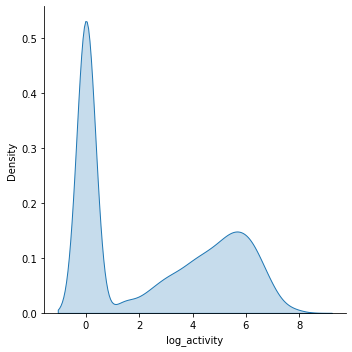

In [10]:
sns.displot(x='log_activity', data=condition_1, kind='kde', fill=True)

In [11]:
condition_1['sqrt_activity'] = np.sqrt(condition_1['activity'])
condition_1['sqrt_activity'].skew()

1.370447546298057

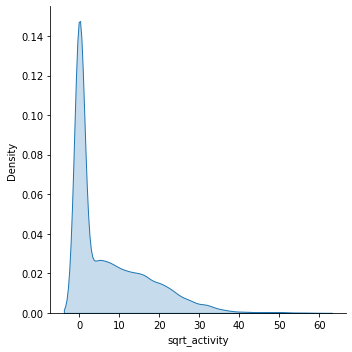

In [12]:
sns.displot(x='sqrt_activity', data=condition_1, kind='kde', fill=True)

In [13]:
condition_1.describe()

,activity,log_activity,sqrt_activity
count,23244.000000,23244.000000,23244.000000
mean,146.948030,2.562035,7.416512
std,294.592424,2.626393,9.588917
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,9.000000,2.302585,3.000000
75%,172.000000,5.153292,13.114877
max,3526.000000,8.168203,59.380131


In [14]:
control_1['activity'].skew()

5.039169993104665

In [15]:
control_1.describe()

,activity
count,51611.000000
mean,98.545078
std,289.655317
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,6117.000000


In [16]:
control_1['log_activity'] = np.log(control_1['activity'] + 1)
control_1['log_activity'].skew()

1.2517081703386566

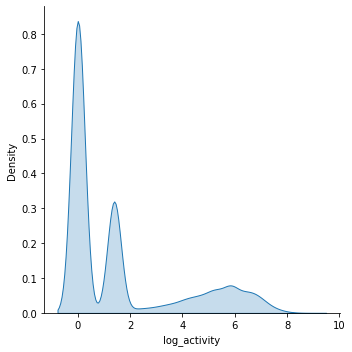

In [17]:
sns.displot(x='log_activity', data=control_1, kind='kde', fill=True)

In [18]:
condition_1.head()

,timestamp,date,activity,log_activity,sqrt_activity
0,2003-05-07 12:00:00,2003-05-07,0,0.000000,0.000000
1,2003-05-07 12:01:00,2003-05-07,143,4.969813,11.958261
2,2003-05-07 12:02:00,2003-05-07,0,0.000000,0.000000
3,2003-05-07 12:03:00,2003-05-07,20,3.044522,4.472136
4,2003-05-07 12:04:00,2003-05-07,166,5.117994,12.884099


In [19]:
df = condition_1.groupby('date')['log_activity'].mean().reset_index()
df.head()

,date,log_activity
0,2003-05-07,3.752204
1,2003-05-08,2.931977
2,2003-05-09,2.593095
3,2003-05-10,2.910573
4,2003-05-11,2.561446


## Time Series Analysis

In [20]:
def combine_data(path):
    dirs = os.listdir(path)
    combine_df = []
    
    for filepath in dirs:
        source = filepath.split('.')[0]
        if filepath.endswith('.csv'):
            X = pd.read_csv(path + filepath, parse_dates=['timestamp'], index_col='timestamp')
            X['source'] = source
            combine_df.append(X)
        
    return combine_df

In [21]:
combine_df = combine_data('/kaggle/input/the-depression-dataset/data/condition/')

In [22]:
conditions = []
for condition in combine_df:
    condition_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    condition_df['mean_activity'] = condition.activity.resample('H').mean()
    condition_df['std_activity'] = condition.activity.resample('H').std()
    condition_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in condition.activity.resample('H')]
    condition_df['source'] = condition.source
    conditions.append(condition_df)

In [23]:
combine_df = combine_data('/kaggle/input/the-depression-dataset/data/control/')

In [24]:
controls = []
for control in combine_df:
    control_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    control_df['mean_activity'] = control.activity.resample('H').mean()
    control_df['std_activity'] = control.activity.resample('H').std()
    control_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in control.activity.resample('H')]
    control_df['source'] = control.source
    controls.append(control_df)

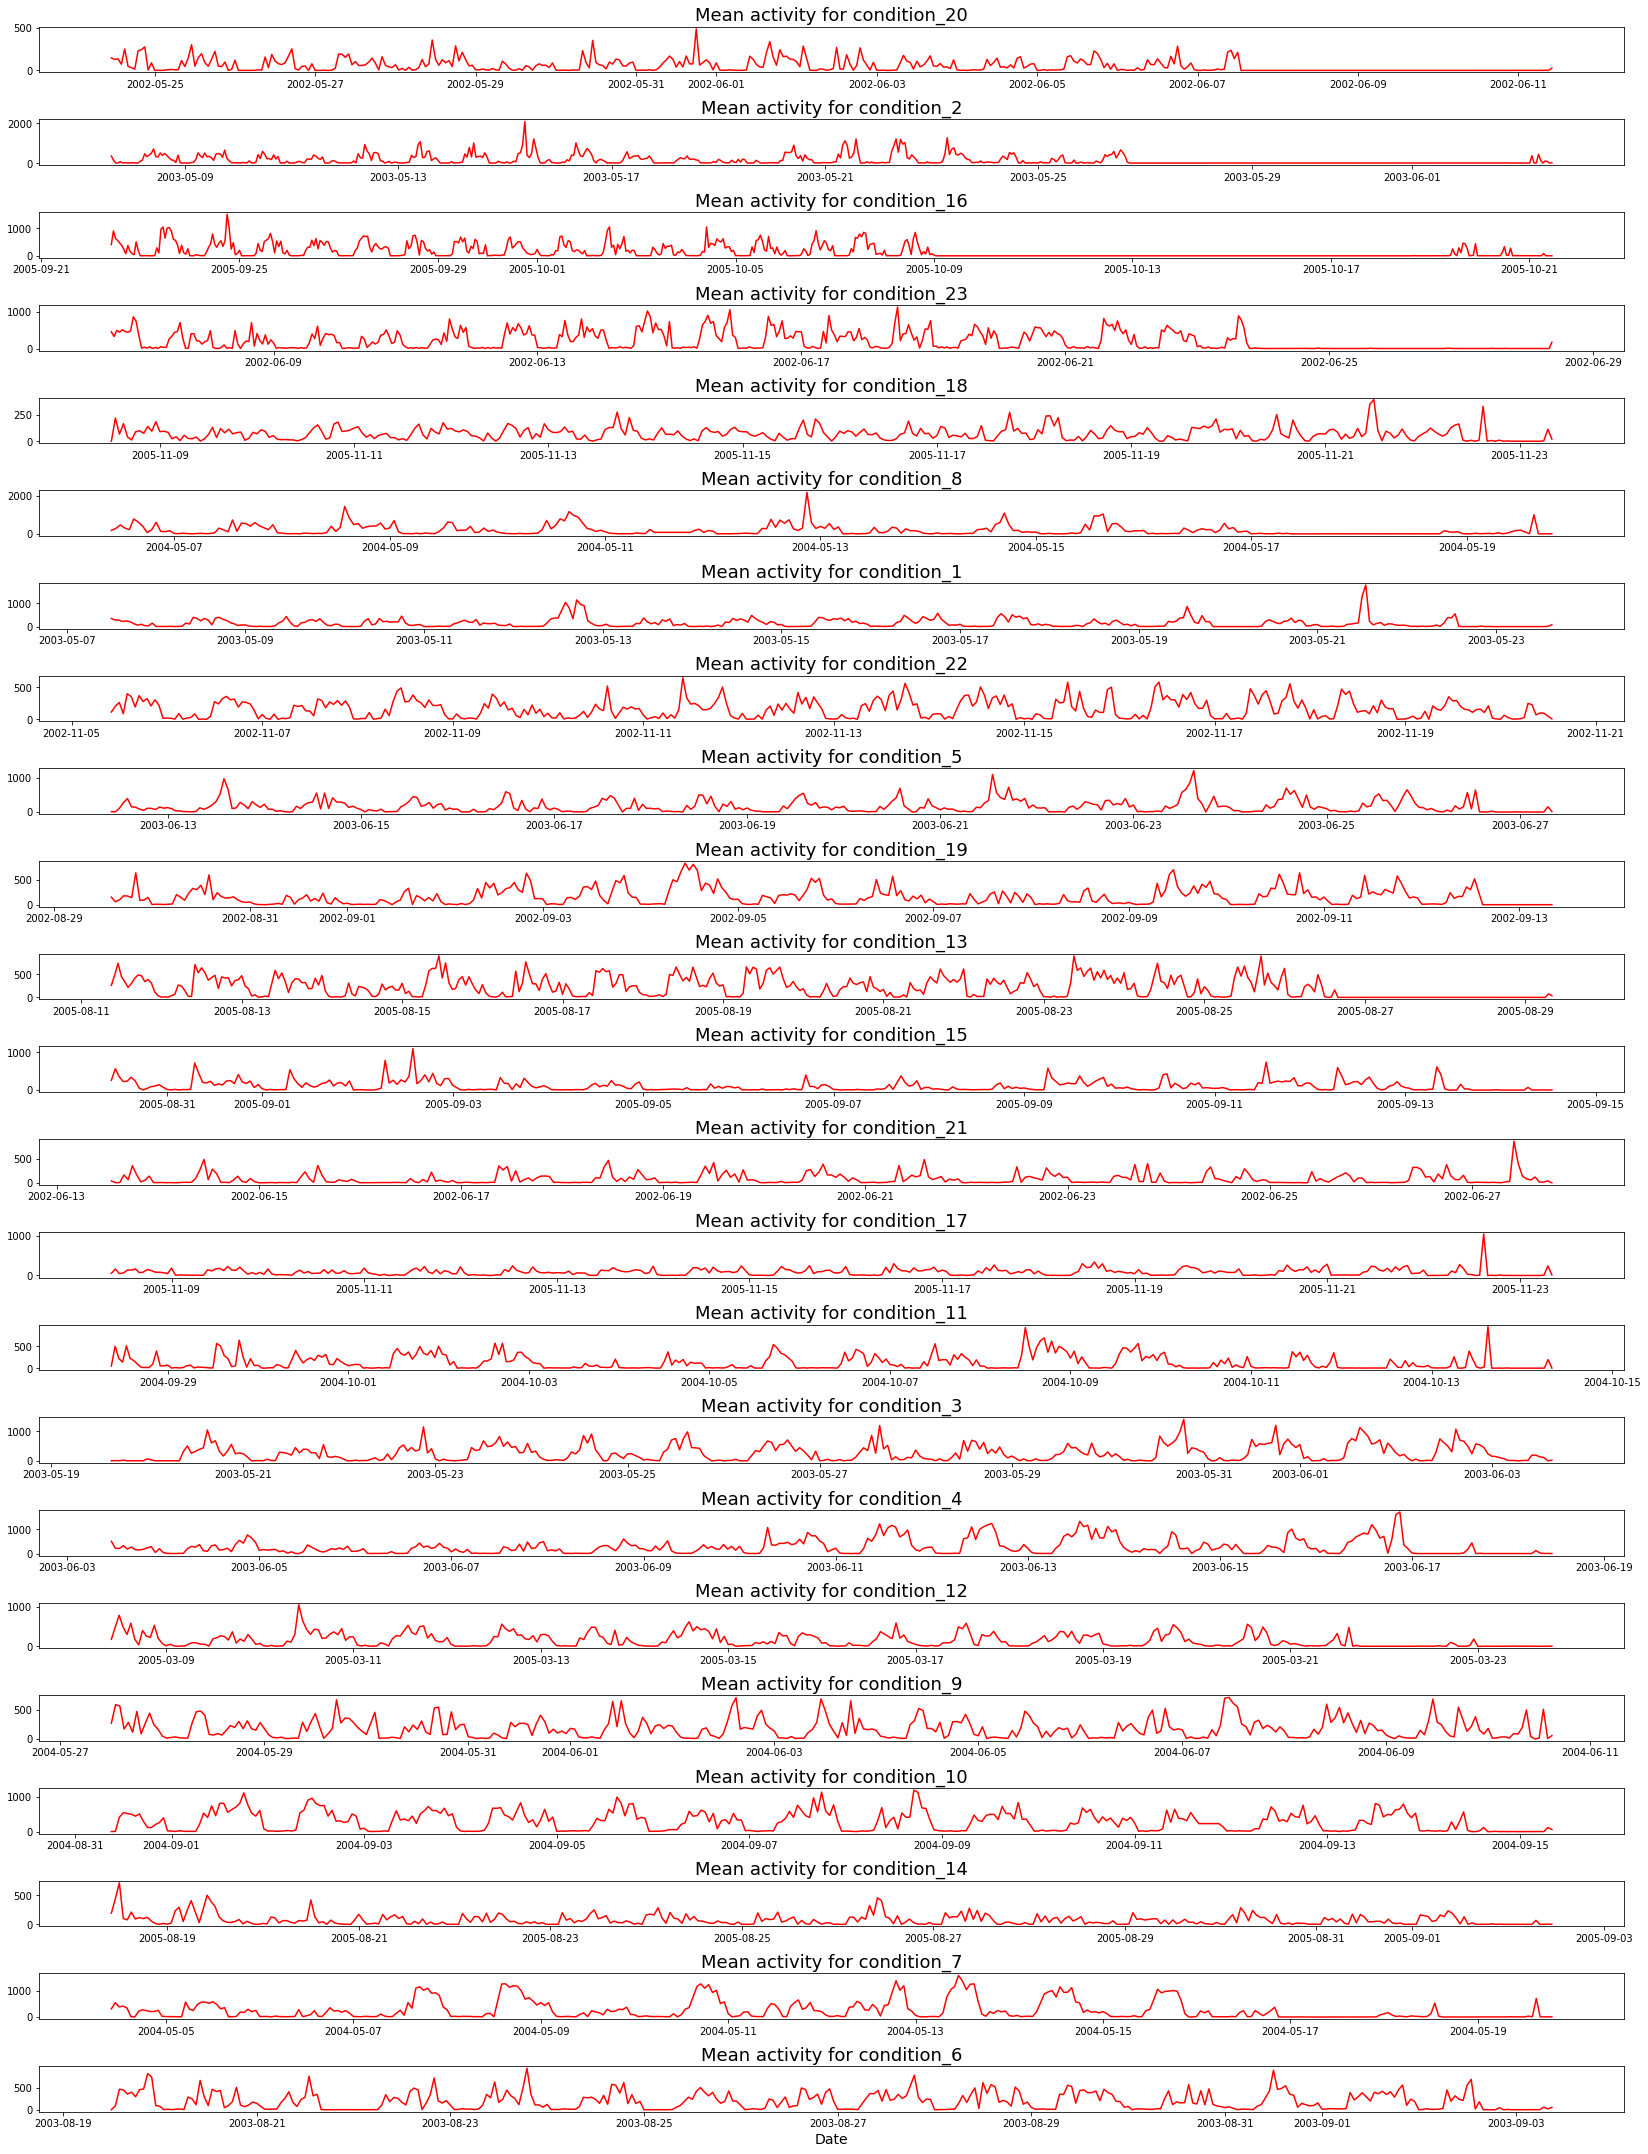

In [25]:
fig, axes = plt.subplots(23, 1, figsize=(23, 30))
cnt = 0
for i in range(23):
    condition = conditions[cnt]
    axes[i].plot(condition.index, condition.mean_activity, color='r')
    axes[i].set_title(f'Mean activity for {condition.source[1]}', fontsize=18)
    cnt += 1
    
plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Mean activity of condition group.jpg', dpi=100)
plt.show()

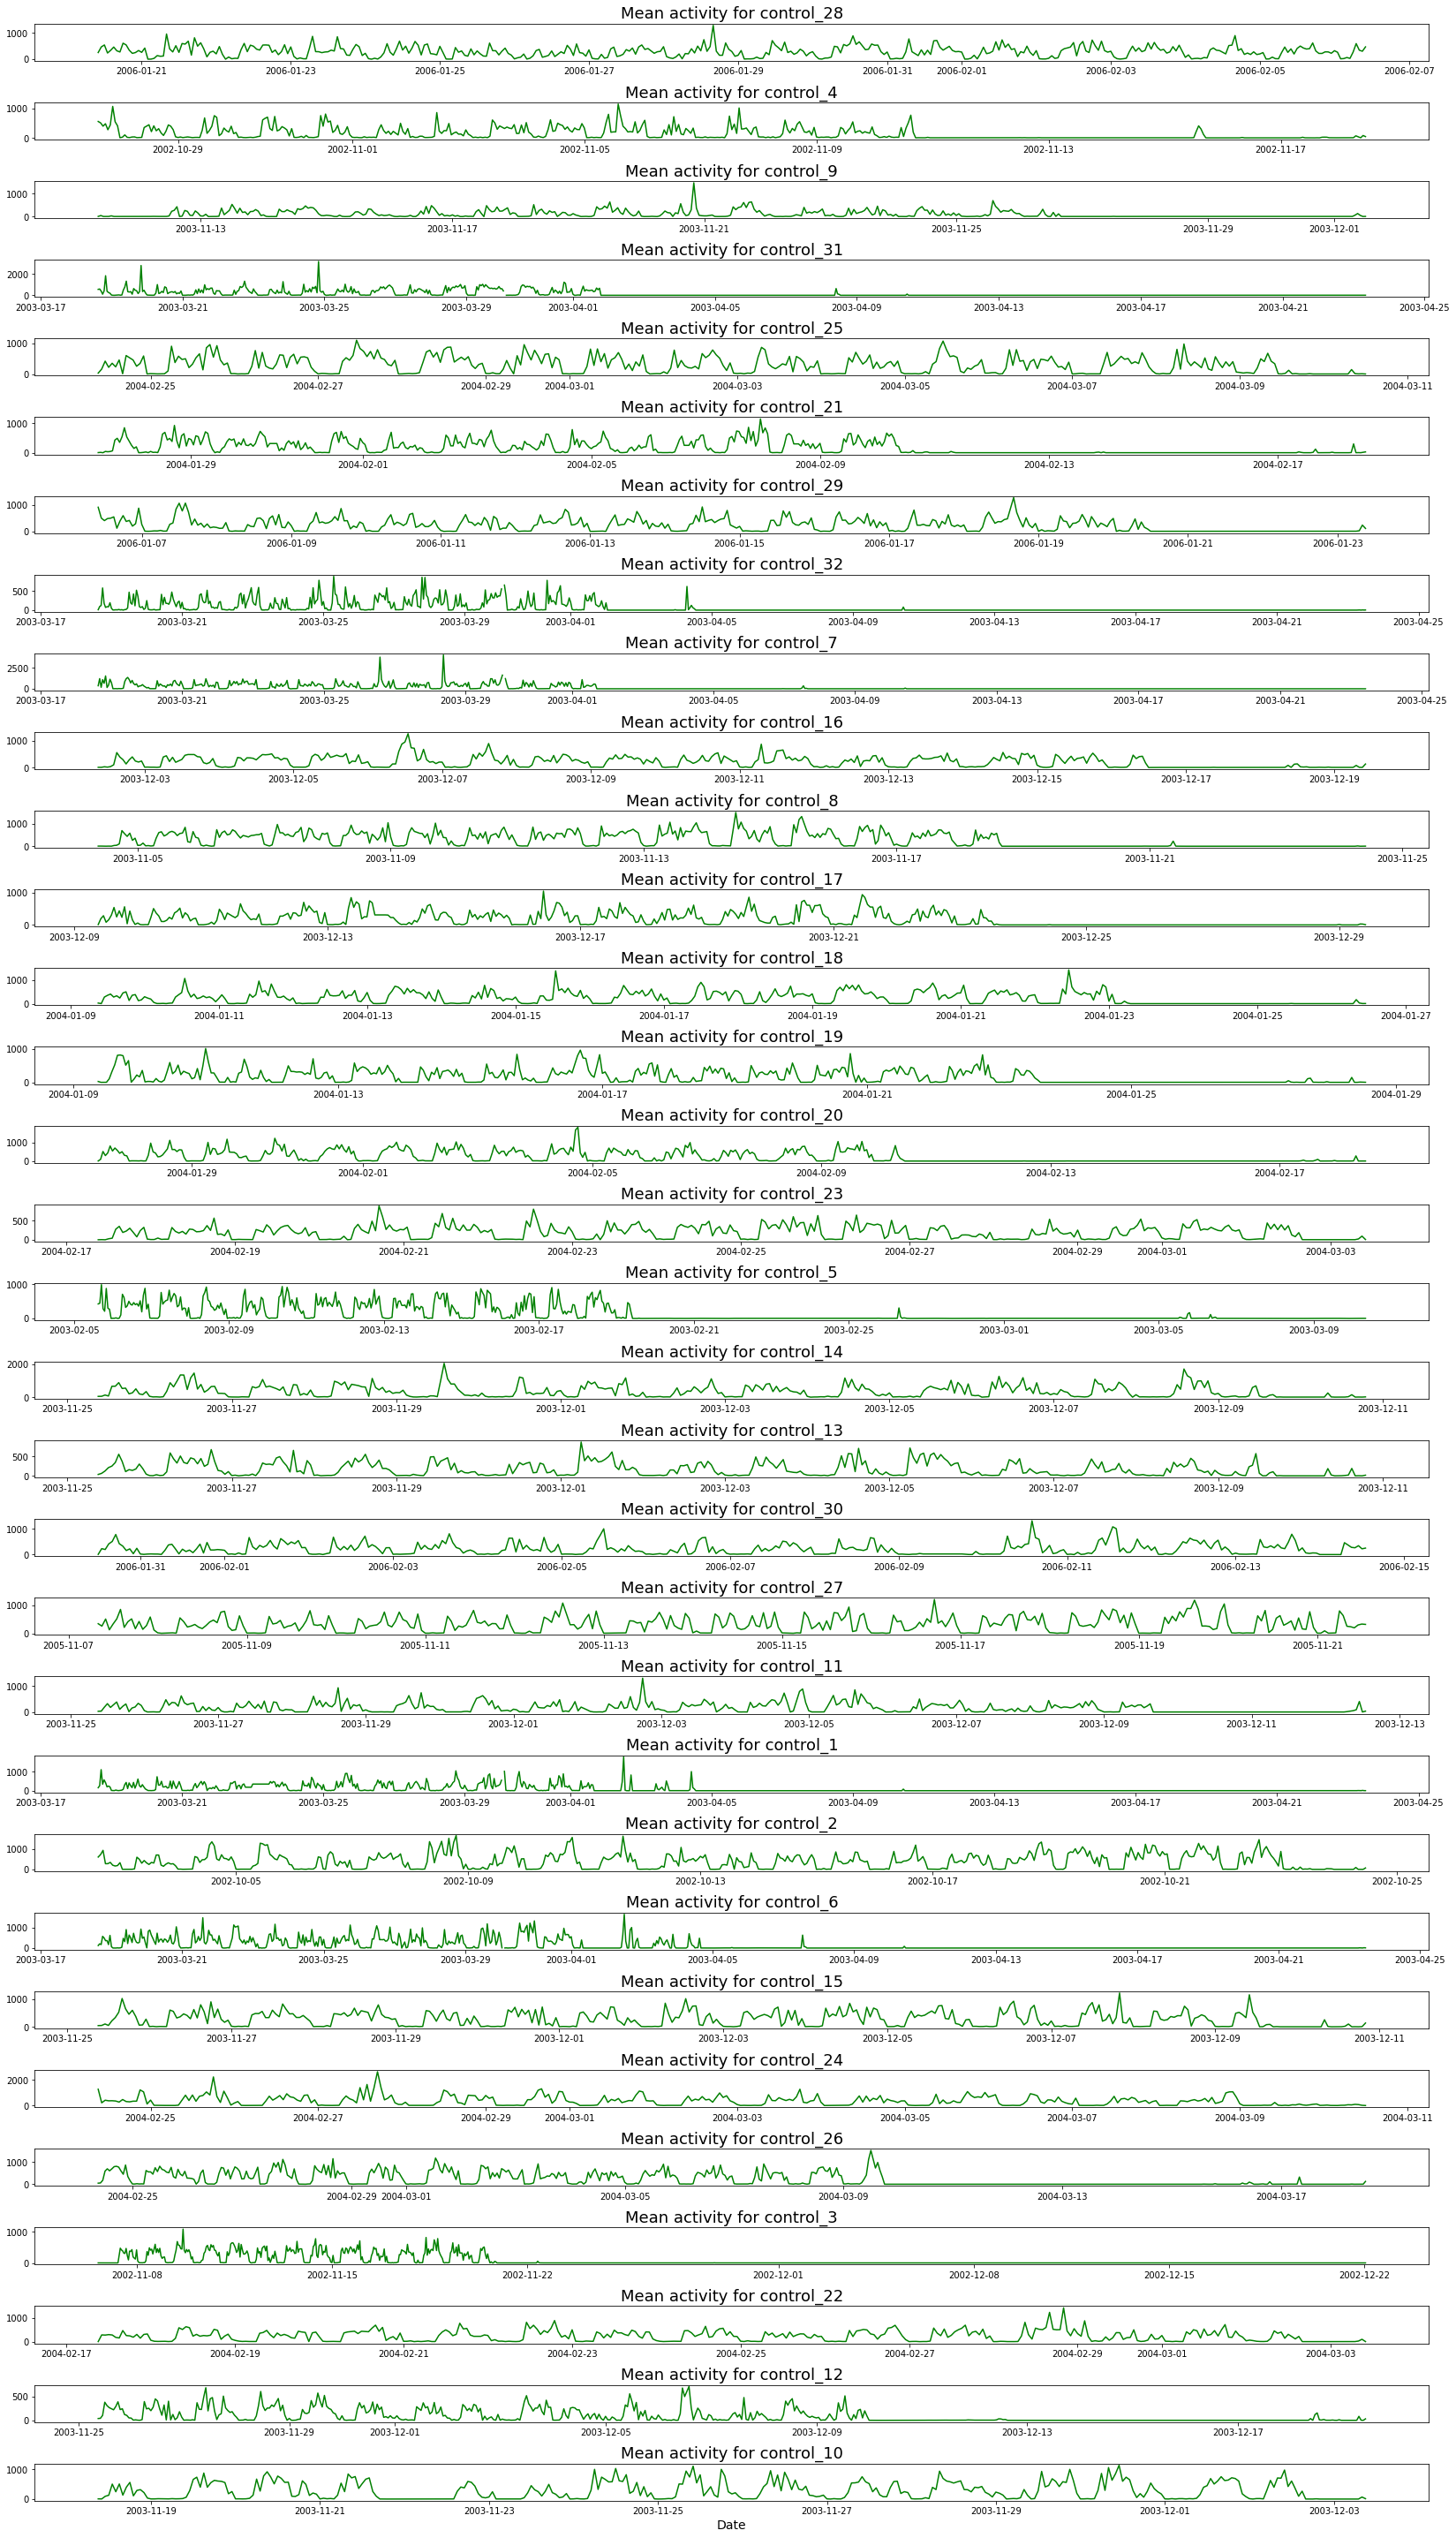

In [26]:
fig, axes = plt.subplots(32, 1, figsize=(23, 40))
cnt = 0
for i in range(32):
    control = controls[cnt]
    axes[i].plot(control.index, control.mean_activity, color='g')
    axes[i].set_title(f'Mean activity for {control.source[1]}', fontsize=18)
    cnt += 1
    
plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Mean activity of control group.jpg', dpi=100)
plt.show()

In [27]:
def to_clock(x):
    d = datetime.strptime(f'{x}:00', '%H:%M')
    return d.strftime('%I:%M %p')

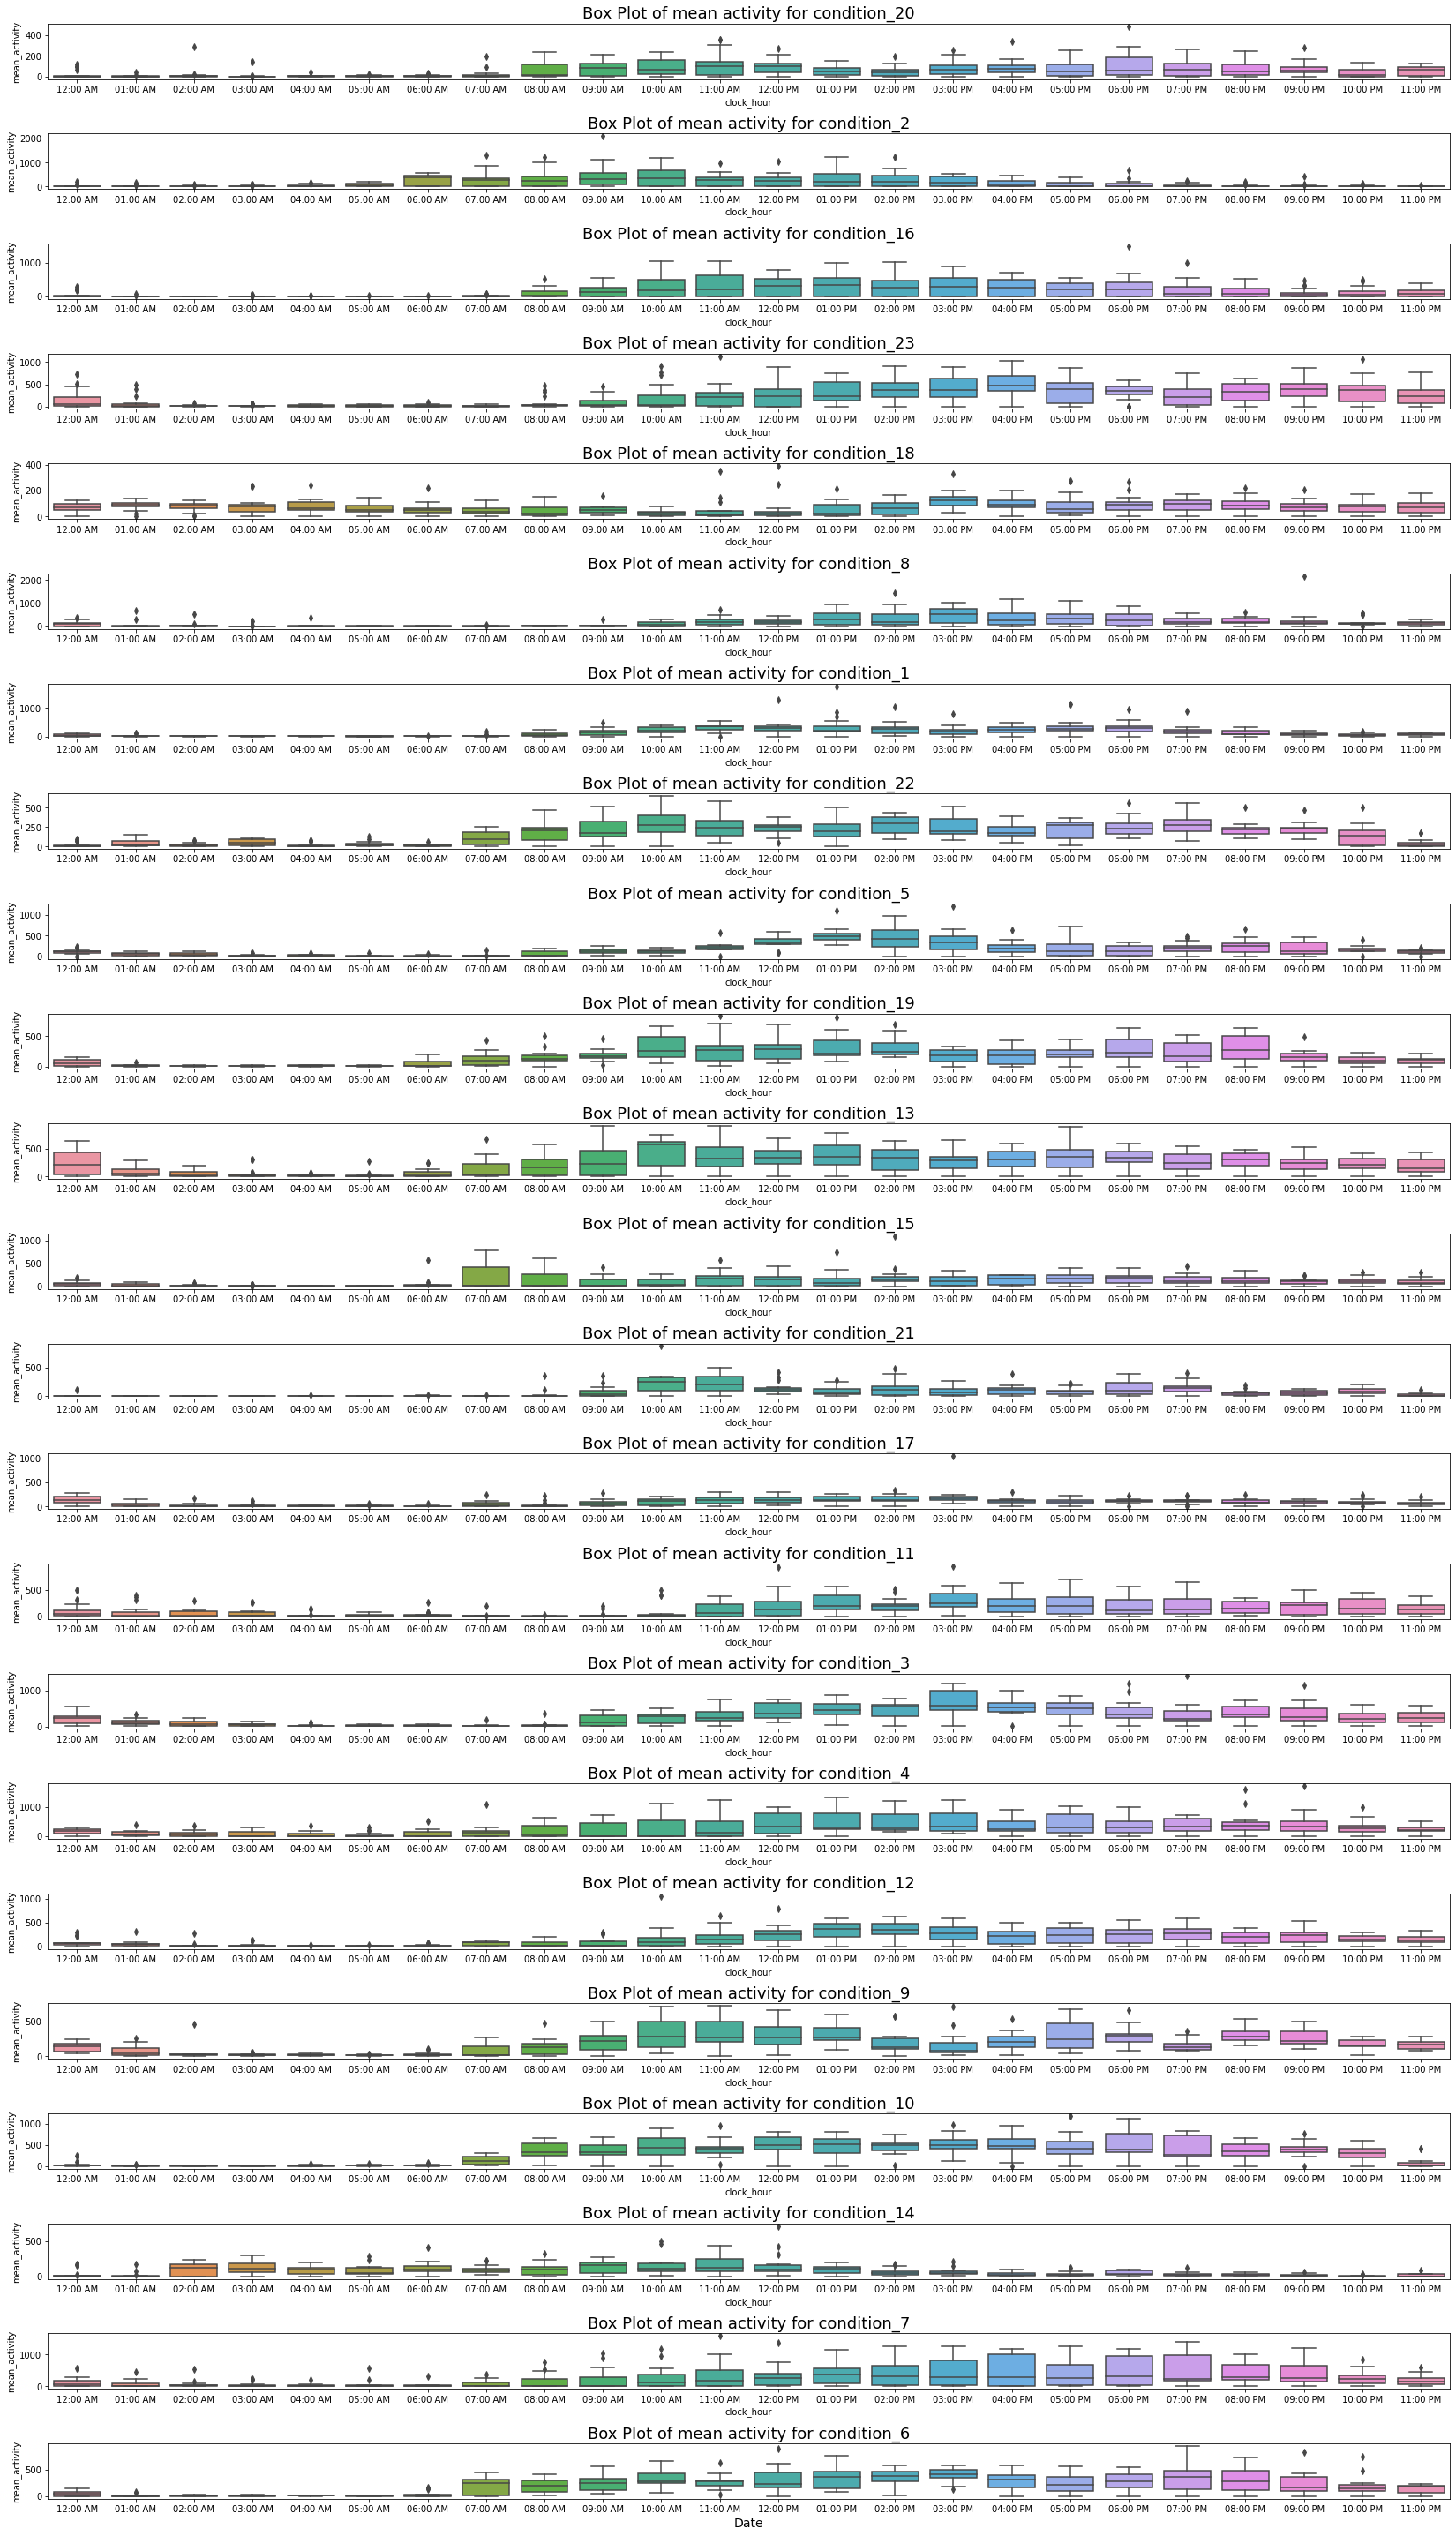

In [28]:
# Draw Plot
fig, axes = plt.subplots(23, 1, figsize=(23, 40))

cnt = 0
for i in range(23):
    df = conditions[i].reset_index()

    # Prepare data
    df['hour'] = [d.hour for d in df.timestamp]
    df = df.sort_values('hour')
    df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
    sns.boxplot(x='clock_hour', y='mean_activity', data=df, ax=axes[i])
    axes[i].set_title(f'Box Plot of mean activity for {df.source[1]}', fontsize=18)
    cnt += 1

plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
plt.show()

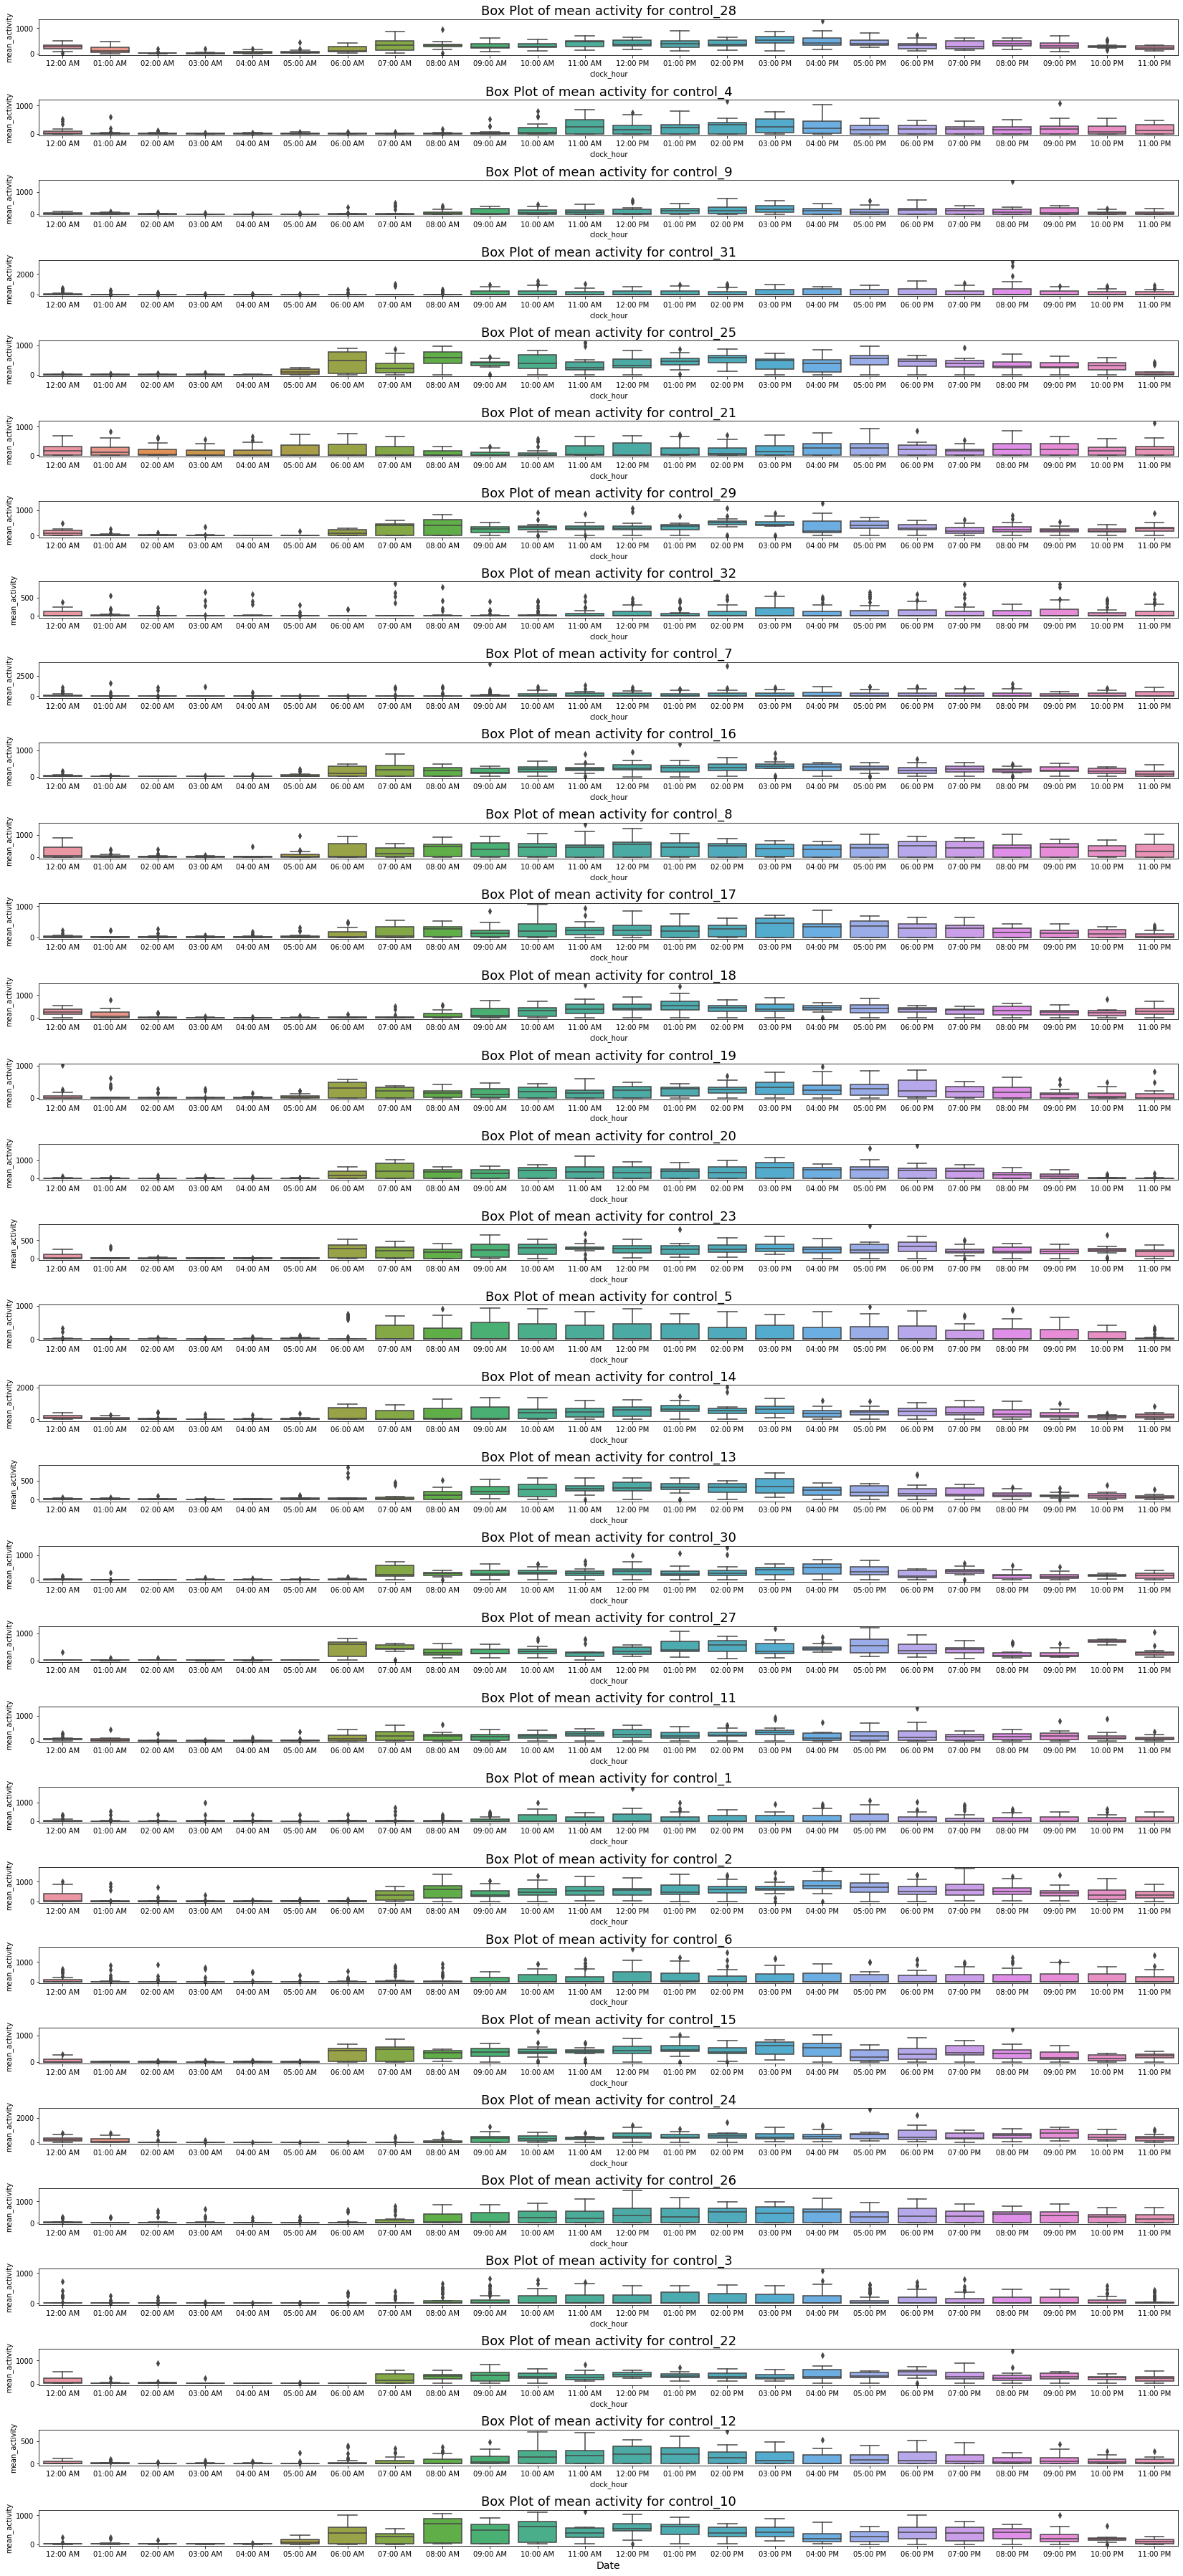

In [29]:
# Draw Plot
fig, axes = plt.subplots(32, 1, figsize=(23, 50))

cnt = 0
for i in range(32):
    df = controls[i].reset_index()

    # Prepare data
    df['hour'] = [d.hour for d in df.timestamp]
    df = df.sort_values('hour')
    df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
    sns.boxplot(x='clock_hour', y='mean_activity', data=df, ax=axes[i])
    axes[i].set_title(f'Box Plot of mean activity for {df.source[1]}', fontsize=18)
    cnt += 1

plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
plt.show()

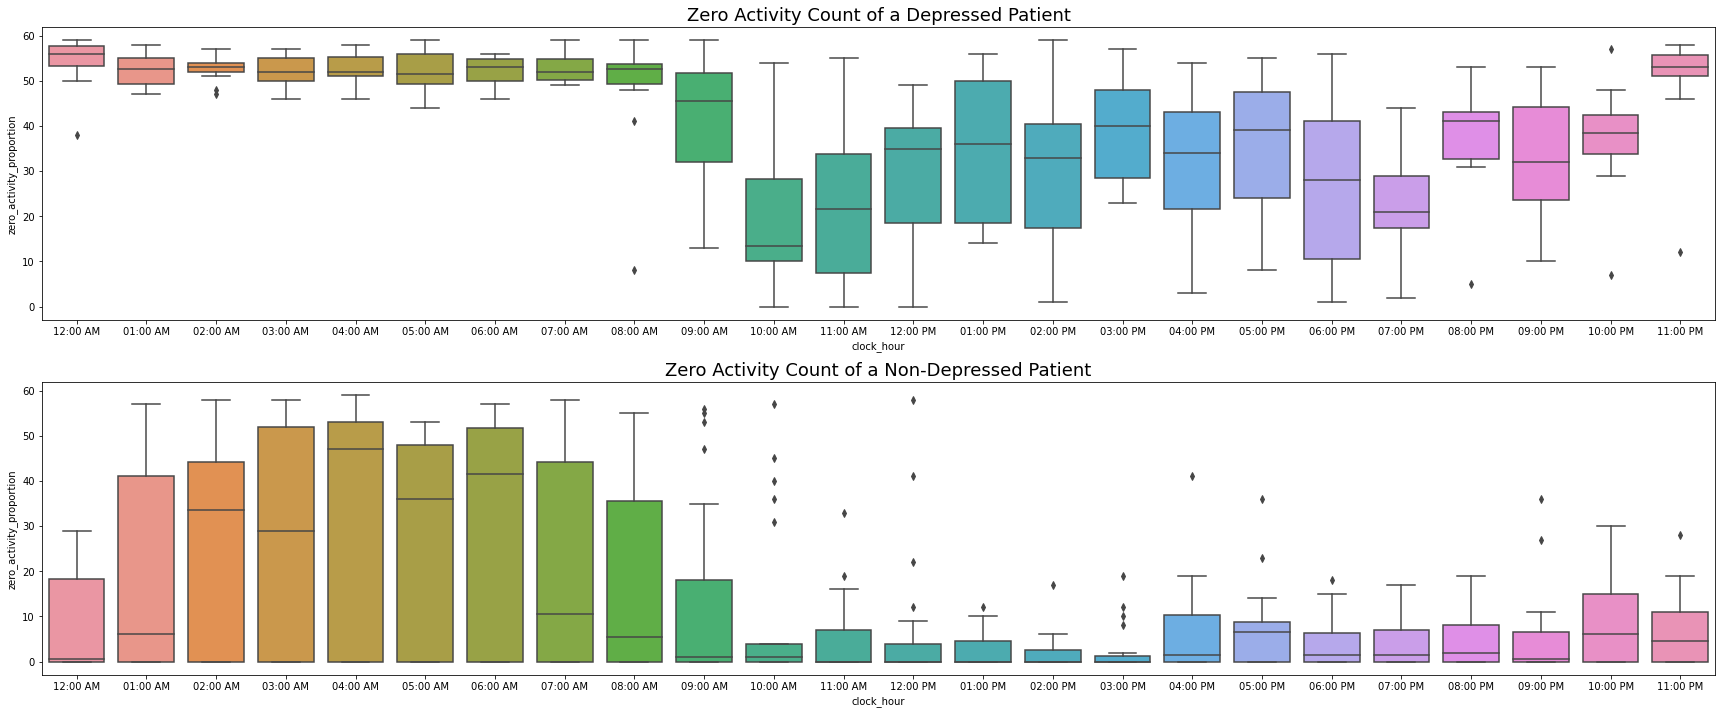

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(24, 10))
df = conditions[12].reset_index()
df['hour'] = [d.hour for d in df.timestamp]
df = df.sort_values('hour')
df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
sns.boxplot(x='clock_hour', y='zero_activity_proportion', data=df, ax=axes[0])
axes[0].set_title('Zero Activity Count of a Depressed Patient', fontsize=18)

df = controls[2].reset_index()
df['hour'] = [d.hour for d in df.timestamp]
df = df.sort_values('hour')
df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
sns.boxplot(x='clock_hour', y='zero_activity_proportion', data=df, ax=axes[1])
axes[1].set_title('Zero Activity Count of a Non-Depressed Patient', fontsize=18)

fig.tight_layout(pad=1.0)
plt.show()

In [31]:
## Clustering Analysis

## Modeling

In [32]:
def nextday(dates):
    for date in dates:
        yield date

In [33]:
def zero_count(series):
    return list(series).count(0)

In [34]:
def extractfeatures(X, date):
    mask = X['date'] == date
    d = {
        'mean_log_activity': X[mask]['log_activity'].mean(),
        'std_log_activity': X[mask]['log_activity'].std(),
        'min_log_activity': X[mask]['log_activity'].min(),
        'max_log_activity': X[mask]['log_activity'].max(),
        'zero_proportion_activity': zero_count(X[mask]['log_activity'])
    }
    return d

In [35]:
class ExtractData(BaseEstimator, TransformerMixin):
    
    def __init__(self, path):
        self.path = path
        self.X = []

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        dirs = os.listdir(self.path)
        
        for filepath in sorted(dirs, key=lambda x: x.split('_')[0]):
            condition = filepath.split('.')[0]
            if filepath.endswith('.csv'):
                X = pd.read_csv(self.path + filepath)
                X['log_activity'] = np.log(X['activity'] + 1)
                dates = X.date.unique()
                
                for date in nextday(dates):
                    d = extractfeatures(X, date)
                    d['source'] = condition
                    self.X.append(d)
                

        return pd.DataFrame(self.X)

In [36]:
e = ExtractData(path='/kaggle/input/the-depression-dataset/data/condition/')
conditions = e.fit_transform(X=None, y=None)
conditions['state'] = 1

In [37]:
conditions.tail()

,mean_log_activity,std_log_activity,min_log_activity,max_log_activity,zero_proportion_activity,source,state
400,2.383962,2.659121,0.0,8.047190,733,condition_6,1
401,2.890593,2.745717,0.0,7.580189,602,condition_6,1
402,3.400727,2.788079,0.0,8.047190,529,condition_6,1
403,1.669743,2.590492,0.0,7.767264,989,condition_6,1
404,0.228577,1.027840,0.0,6.502790,523,condition_6,1


In [38]:
e = ExtractData(path='/kaggle/input/the-depression-dataset/data/control/')
controls = e.fit_transform(X=None, y=None)
controls['state'] = 0

In [39]:
full_df = controls.append(conditions, ignore_index=True)
full_df.head()

,mean_log_activity,std_log_activity,min_log_activity,max_log_activity,zero_proportion_activity,source,state
0,5.232499,1.494106,0.0,7.976595,24,control_28,0
1,4.103117,2.658716,0.0,8.657129,359,control_28,0
2,4.057168,2.617790,0.0,8.007367,366,control_28,0
3,4.094460,2.587575,0.0,7.852050,350,control_28,0
4,4.118694,2.542314,0.0,8.100768,344,control_28,0


In [40]:
full_df.shape

(1144, 7)

In [41]:
full_df = full_df.sample(frac=1) # reshufle the dataset


In [42]:
def custom_train_test_split(train_set, test_set):
    X_train = train_set.drop('label', axis=1)
    y_train = train_set.label
    X_test = test_set.drop('label', axis=1)
    y_test = test_set.label
    
    return X_train, X_test, y_train, y_test


In [43]:
class CustomClassifierCV(BaseEstimator, TransformerMixin):
    
    def __init__(self, base_clf):
        self.base_clf = base_clf
    
    def fit(self, X, y=None):
        X['label'] = y
        participants = X.source.unique()
        folds = []
        
        predictions = [] # predicted labels
        actuals = [] # actual labels
            
        for p in participants:
            folds.append(X[X['source'] == p])
        
        for i in range(len(folds)):   
            test_set = folds[i]
            train_fold = [elem for idx , elem in enumerate(folds) if idx != i]
            
            train_set = pd.concat(train_fold)
            X_train, X_test, y_train, y_test = custom_train_test_split(train_set.drop(['source'], axis=1),
                                    test_set.drop(['source'], axis=1))
            
            self.base_clf.fit(X_train, y_train)
            predictions.append(self.predict(X_test))
            actuals.append(test_set.label.iloc[0])
            
        self.score(predictions, actuals)
        
    def predict(self, X):
        predictions = self.base_clf.predict(X)
        ones = predictions.tolist().count(1)
        zeroes = predictions.tolist().count(0)
        
        return 1 if ones > zeroes else 0
    
    def score(self, predictions, actuals):
        print(classification_report(predictions, actuals))

In [44]:
X = full_df.drop(['state'], axis=1)
y = full_df.state

In [45]:
X.source

769      condition_2
434       control_30
163       control_32
509        control_1
837     condition_23
            ...     
1118     condition_7
557        control_6
762      condition_2
119       control_21
87        control_31
Name: source, Length: 1144, dtype: object

In [46]:
# build the lightgbm model
import lightgbm as lgb
clf1 = lgb.LGBMClassifier()
custom_clfCV = CustomClassifierCV(clf1)
custom_clfCV.fit(X, y)



              precision    recall  f1-score   support

           0       0.94      0.68      0.79        44
           1       0.39      0.82      0.53        11

    accuracy                           0.71        55
   macro avg       0.66      0.75      0.66        55
weighted avg       0.83      0.71      0.74        55



In [47]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [48]:
from xgboost import XGBClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

clf2=XGBClassifier(objective="binary:logistic",eval_metric="error",n_estimators=100, max_depth = 2, random_state = 42)
custom_clfCV = CustomClassifierCV(clf2)
custom_clfCV.fit(X, y)

              precision    recall  f1-score   support

           0       0.91      0.69      0.78        42
           1       0.43      0.77      0.56        13

    accuracy                           0.71        55
   macro avg       0.67      0.73      0.67        55
weighted avg       0.79      0.71      0.73        55



In [49]:
from sklearn.ensemble import GradientBoostingClassifier
clf3=GradientBoostingClassifier(n_estimators=100,  max_features=2, max_depth = 2, random_state = 42)
custom_clfCV = CustomClassifierCV(clf3)
custom_clfCV.fit(X, y)

              precision    recall  f1-score   support

           0       0.88      0.70      0.78        40
           1       0.48      0.73      0.58        15

    accuracy                           0.71        55
   macro avg       0.68      0.72      0.68        55
weighted avg       0.77      0.71      0.72        55



In [50]:
from sklearn.ensemble import AdaBoostClassifier
clf4=AdaBoostClassifier(random_state = 42)
custom_clfCV = CustomClassifierCV(clf4)
custom_clfCV.fit(X, y)

              precision    recall  f1-score   support

           0       0.91      0.71      0.79        41
           1       0.48      0.79      0.59        14

    accuracy                           0.73        55
   macro avg       0.69      0.75      0.69        55
weighted avg       0.80      0.73      0.74        55



In [51]:
from sklearn.neural_network import MLPClassifier

clf5 = MLPClassifier()
custom_clfCV = CustomClassifierCV(clf5)
custom_clfCV.fit(X, y)

              precision    recall  f1-score   support

           0       0.84      0.60      0.70        45
           1       0.22      0.50      0.30        10

    accuracy                           0.58        55
   macro avg       0.53      0.55      0.50        55
weighted avg       0.73      0.58      0.63        55



In [52]:
from sklearn.neighbors import KNeighborsClassifier
clf6 = KNeighborsClassifier()
custom_clfCV = CustomClassifierCV(clf6)
custom_clfCV.fit(X, y)


              precision    recall  f1-score   support

           0       0.91      0.67      0.77        43
           1       0.39      0.75      0.51        12

    accuracy                           0.69        55
   macro avg       0.65      0.71      0.64        55
weighted avg       0.79      0.69      0.72        55



In [53]:
from sklearn.svm import SVC
clf7 = SVC(random_state=42)
custom_clfCV = CustomClassifierCV(clf7)
custom_clfCV.fit(X, y)

              precision    recall  f1-score   support

           0       1.00      0.63      0.77        51
           1       0.17      1.00      0.30         4

    accuracy                           0.65        55
   macro avg       0.59      0.81      0.53        55
weighted avg       0.94      0.65      0.74        55



In [54]:
from sklearn.tree import DecisionTreeClassifier
clf8 = DecisionTreeClassifier(random_state=42)
custom_clfCV = CustomClassifierCV(clf8)
custom_clfCV.fit(X, y)


              precision    recall  f1-score   support

           0       0.88      0.67      0.76        42
           1       0.39      0.69      0.50        13

    accuracy                           0.67        55
   macro avg       0.63      0.68      0.63        55
weighted avg       0.76      0.67      0.70        55



In [55]:
forest = RandomForestClassifier(n_estimators=100)
custom_clfCV = CustomClassifierCV(forest)
custom_clfCV.fit(X, y)

              precision    recall  f1-score   support

           0       0.94      0.68      0.79        44
           1       0.39      0.82      0.53        11

    accuracy                           0.71        55
   macro avg       0.66      0.75      0.66        55
weighted avg       0.83      0.71      0.74        55



In [56]:
import pickle

In [57]:
pickle.dump(clf4,open("adboost_classifier.pkl","wb"))